In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from scipy.linalg import eigh
import pennylane as qml
from scipy.linalg import expm

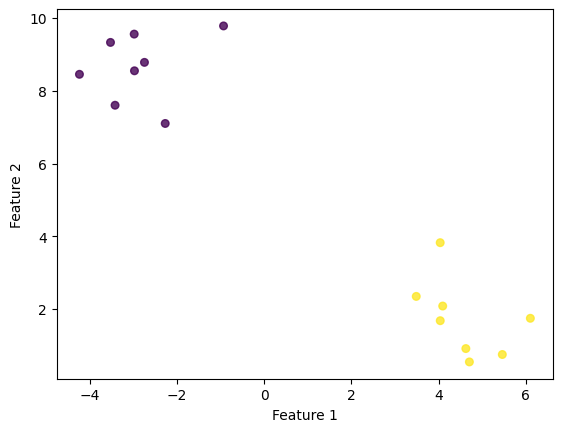

(16, 16)


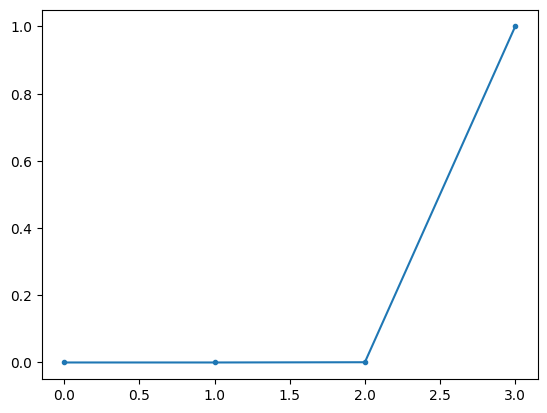

In [209]:
# data generation
X, Y = datasets.make_blobs(n_samples=16, centers=2, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='viridis', s=30, alpha=0.8)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# matrices
A = np.exp(-pairwise_distances(X, metric='euclidean'))
D = np.diag(np.sum(A, axis=1))
L = D - A
L_inv = np.linalg.inv(L + np.eye(L.shape[0]) * 1e-6)
L_inv_norm = L_inv / np.linalg.norm(L_inv)
# L_inv_norm = np.linalg.matrix_power(L_inv_norm, 5)
print(L_inv_norm.shape)

# eigendecomposition for reference
inv_val, inv_vec = eigh(L_inv_norm)
plt.plot(inv_val[-4:],'.-')
plt.show()

In [210]:
# check if a matrix is Hermitian
def check_hermitain(A):
    return np.allclose(A, A.conj().T)

def check_unitary(A):
    I = np.eye(A.shape[0])
    return np.allclose(A.conj().T @ A, I) and np.allclose(A @ A.conj().T, I)

print("hermitian : ", check_hermitain(L), check_hermitain(L_inv), check_hermitain(L_inv_norm))
print("unitary : ", check_unitary(L), check_unitary(L_inv), check_unitary(L_inv_norm))
print("unitary : ", check_unitary(expm(-1j*L)), check_unitary(expm(-1j*L_inv)), check_unitary(expm(-1j*L_inv_norm)))

hermitian :  True True True
unitary :  False False False
unitary :  True True True


In [212]:
# quantum power method based on the blaock encoding
L_dec = qml.pauli_decompose(L_inv_norm)
coeff, op = L_dec.terms()
print(len(L_dec))

128


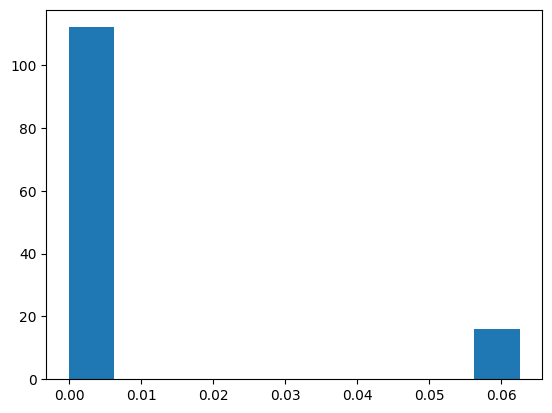

In [213]:
plt.hist(coeff)
plt.show()

In [214]:
red_idx = []
for idx, val in enumerate(coeff):
    if val>0.05:
        red_idx.append(idx)
        
coeff_red = [coeff[i] for i in red_idx]
op_red = [op[i] for i in red_idx]
len(coeff_red)

16

In [215]:
dev = qml.device("default.qubit", wires=8) 
reg = qml.registers({"control": 4, "target": 4}) 
norm_coeff = (np.sqrt(coeff_red) / np.linalg.norm(np.sqrt(coeff_red)))
# scaling_factor = sum(abs(norm_coeff))

# shifing wires for unitaries
unitaries = [qml.map_wires(op_elem, {i: i + 4 for i in range(4)}) for op_elem in op_red]

def block_encoding():
    qml.StatePrep(norm_coeff, wires=reg['control'])
    qml.Select(unitaries, control=reg['control'])
    qml.adjoint(qml.StatePrep(norm_coeff, wires=reg['control']))

@qml.qnode(dev)
def power_method():
    # for i in reg['target']:
    #     qml.Hadamard(i)
    block_encoding()
    return qml.state() # qml.expval(qml.Hermitian(L_inv_norm, wires=reg['target']))

# qml.draw_mpl(power_method, style='pennylane')()
# plt.show()

In [218]:
output_matrix = qml.matrix(power_method)()
print("L_inv_norm:\n", pd.DataFrame(L_inv_norm), "\n")

submatrix = output_matrix[:16, :16]
print("Block-encoded L_inv_norm:\n")
print(pd.DataFrame(np.real(np.round(submatrix,5)))) # 

L_inv_norm:
           0         1         2         3         4         5         6   \
0   0.062546  0.062546  0.062546  0.062546  0.062454  0.062546  0.062454   
1   0.062546  0.062546  0.062546  0.062546  0.062454  0.062546  0.062454   
2   0.062546  0.062546  0.062546  0.062546  0.062454  0.062546  0.062454   
3   0.062546  0.062546  0.062546  0.062546  0.062454  0.062546  0.062454   
4   0.062454  0.062454  0.062454  0.062454  0.062546  0.062454  0.062546   
5   0.062546  0.062546  0.062546  0.062546  0.062454  0.062546  0.062454   
6   0.062454  0.062454  0.062454  0.062454  0.062546  0.062454  0.062546   
7   0.062454  0.062454  0.062454  0.062454  0.062546  0.062454  0.062546   
8   0.062454  0.062454  0.062454  0.062454  0.062546  0.062454  0.062546   
9   0.062454  0.062454  0.062454  0.062454  0.062546  0.062454  0.062546   
10  0.062546  0.062546  0.062546  0.062546  0.062454  0.062546  0.062454   
11  0.062454  0.062454  0.062454  0.062454  0.062546  0.062454  0.062546   

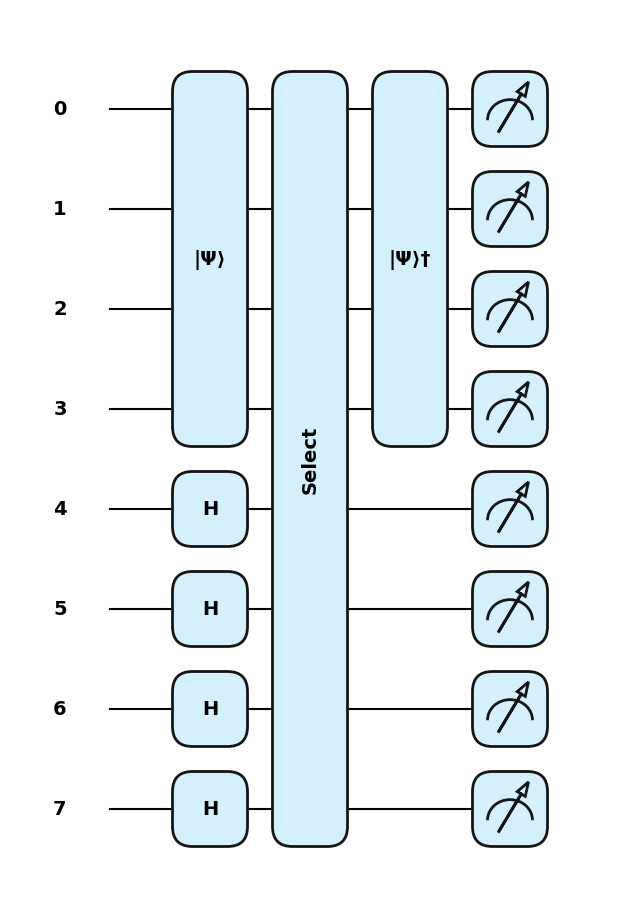

In [219]:
dev = qml.device("default.qubit", wires=8) 
reg = qml.registers({"control": 4, "target": 4}) 
norm_coeff = (np.sqrt(coeff_red) / np.linalg.norm(np.sqrt(coeff_red)))
# scaling_factor = sum(abs(norm_coeff))

# shifing wires for unitaries
unitaries = [qml.map_wires(op_elem, {i: i + 4 for i in range(4)}) for op_elem in op_red]

def block_encoding():
    qml.StatePrep(norm_coeff, wires=reg['control'])
    qml.Select(unitaries, control=reg['control'])
    qml.adjoint(qml.StatePrep(norm_coeff, wires=reg['control']))

@qml.qnode(dev)
def power_method():
    for i in reg['target']:
        qml.Hadamard(i)
    block_encoding()
    return qml.state() # qml.expval(qml.Hermitian(L_inv_norm, wires=reg['target']))

qml.draw_mpl(power_method, style='pennylane')()
plt.show()

In [220]:
# post-processing
def select_indices_multi(n_qubits, measured_wires, outcomes):
    return [
        i for i in range(2 ** n_qubits)
        if all(format(i, f'0{n_qubits}b')[wire] == str(outcome) 
               for wire, outcome in zip(measured_wires, outcomes))
    ]
    
state = power_method()
indices = select_indices_multi(n_qubits=8, measured_wires=[0, 1, 2, 3], outcomes=[0,0,0,0])
projected = np.array([state[i] for i in indices])
print(len(np.real(projected)), np.real(projected))
post_selected = projected / np.linalg.norm(projected)
print(np.real(post_selected)) # get the constant vector - correct!

16 [0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25]
[0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 0.25 0.25]


In [221]:
# expectation value?
@qml.qnode(dev)
def power_method():
    for i in reg['target']:
        qml.Hadamard(i)
    block_encoding()
    return qml.expval(qml.Hermitian(L_inv_norm, wires=reg['target']))

d_eig = math.pow(power_method(),1/3)
d_eig # correct

0.9999999102252705

In [222]:
@qml.qnode(dev)
def pm(L_inv_norm):
    for i in reg['target']:
        qml.Hadamard(i)
    block_encoding()
    return qml.expval(qml.Hermitian(L_inv_norm, wires=reg['target'])), qml.state()

def select_indices_multi(n_qubits, measured_wires, outcomes):
    return [
        i for i in range(2 ** n_qubits)
        if all(format(i, f'0{n_qubits}b')[wire] == str(outcome) 
               for wire, outcome in zip(measured_wires, outcomes))]
    
val, vec = pm(L_inv_norm)
def post_pm(val, vec):
    indices = select_indices_multi(n_qubits=8, measured_wires=[0, 1, 2, 3], outcomes=[0,0,0,0])
    projected = np.array([state[i] for i in indices])
    post_selected = projected / np.linalg.norm(projected)
    return math.pow(val, 1/3), post_selected

val, vec = post_pm(val,vec)

In [241]:
def deflate(A, eig_val, eig_vec):
    return A - eig_val * np.outer(eig_vec, eig_vec)

def_mat = deflate(def_mat, eig_val, eig_vec)

def_val = []
def_vec = []

def_val.append(val)
def_vec.append(vec)

pd.DataFrame(np.real(def_mat))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.124954,-0.124954,-0.124954,-0.124954,-0.125046,-0.124954,-0.125046,-0.125046,-0.125046,-0.125046,-0.124954,-0.125046,-0.125046,-0.124954,-0.125046,-0.124954
1,-0.124954,-0.124954,-0.124954,-0.124954,-0.125046,-0.124954,-0.125046,-0.125046,-0.125046,-0.125046,-0.124954,-0.125046,-0.125046,-0.124954,-0.125046,-0.124954
2,-0.124954,-0.124954,-0.124954,-0.124954,-0.125046,-0.124954,-0.125046,-0.125046,-0.125046,-0.125046,-0.124954,-0.125046,-0.125046,-0.124954,-0.125046,-0.124954
3,-0.124954,-0.124954,-0.124954,-0.124954,-0.125046,-0.124954,-0.125046,-0.125046,-0.125046,-0.125046,-0.124954,-0.125046,-0.125046,-0.124954,-0.125046,-0.124955
4,-0.125046,-0.125046,-0.125046,-0.125046,-0.124954,-0.125046,-0.124954,-0.124954,-0.124954,-0.124954,-0.125046,-0.124954,-0.124954,-0.125046,-0.124954,-0.125046
5,-0.124954,-0.124954,-0.124954,-0.124954,-0.125046,-0.124954,-0.125046,-0.125046,-0.125046,-0.125046,-0.124954,-0.125046,-0.125046,-0.124954,-0.125046,-0.124954
6,-0.125046,-0.125046,-0.125046,-0.125046,-0.124954,-0.125046,-0.124954,-0.124954,-0.124954,-0.124954,-0.125046,-0.124954,-0.124954,-0.125046,-0.124954,-0.125046
7,-0.125046,-0.125046,-0.125046,-0.125046,-0.124954,-0.125046,-0.124954,-0.124953,-0.124954,-0.124954,-0.125046,-0.124954,-0.124954,-0.125046,-0.124954,-0.125046
8,-0.125046,-0.125046,-0.125046,-0.125046,-0.124954,-0.125046,-0.124954,-0.124954,-0.124953,-0.124954,-0.125046,-0.124954,-0.124954,-0.125046,-0.124955,-0.125046
9,-0.125046,-0.125046,-0.125046,-0.125046,-0.124954,-0.125046,-0.124954,-0.124954,-0.124954,-0.124954,-0.125046,-0.124954,-0.124954,-0.125046,-0.124954,-0.125046


In [244]:
# quantum power method based on the blaock encoding
L_dec = qml.pauli_decompose(def_mat)
coeff, op = L_dec.terms()
print(len(L_dec))

128


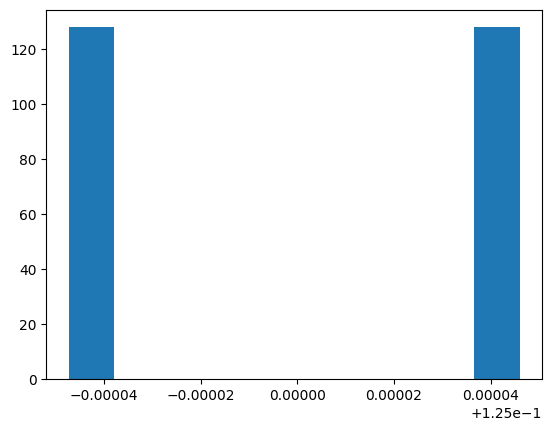

In [245]:
plt.hist(abs(np.real(def_mat).flatten()))
plt.show()

In [ ]:
red_idx = []
for idx, val in enumerate(coeff):
    if val>0.05:
        red_idx.append(idx)
        
coeff_red = [coeff[i] for i in red_idx]
op_red = [op[i] for i in red_idx]
len(coeff_red)

In [248]:
N = 64
red_idx = np.argsort(np.abs(coeff))[-N:][::-1]

coeff_red = [coeff[i] for i in red_idx]
op_red = [op[i] for i in red_idx]
len(op_red)

64

In [252]:
op_red[0]

X(0) @ I(1) @ I(2) @ X(3)

In [251]:
dev = qml.device("default.qubit", wires=16) 
reg = qml.registers({"control": 8, "target": 8}) 
norm_coeff = (np.sqrt(coeff_red) / np.linalg.norm(np.sqrt(coeff_red)))
# scaling_factor = sum(abs(norm_coeff))

# shifing wires for unitaries
unitaries = [qml.map_wires(op_elem, {i: i + 8 for i in range(8)}) for op_elem in op_red]

def block_encoding():
    qml.StatePrep(norm_coeff, wires=reg['control'])
    qml.Select(unitaries, control=reg['control'])
    qml.adjoint(qml.StatePrep(norm_coeff, wires=reg['control']))

@qml.qnode(dev)
def pm(A):
    for i in reg['target']:
        qml.Hadamard(i)
    block_encoding()
    return qml.expval(qml.Hermitian(A, wires=reg['target'])), qml.state()

val, vec = pm(def_mat)
def post_pm(val, vec):
    indices = select_indices_multi(n_qubits=16, measured_wires=range(8), outcomes=np.zeros(8))
    projected = np.array([state[i] for i in indices])
    post_selected = projected / np.linalg.norm(projected)
    return math.pow(val, 1/3), post_selected

val, vec = post_pm(val,vec)

ValueError: State must be of length 256; got length 64. Use the 'pad_with' argument for automated padding.